# Seasonal Demand Prediction in Retail Stores

## Problem Statement
Predict demand for seasonal products in retail stores with high accuracy (>90%).

## Problem Description
Seasonal demand fluctuates. An ML model can analyze historical sales and environmental factors to predict trends.

This project implements:
1. **Advanced Feature Engineering**: Lags, Rolling Statistics, and Date-based features.
2. **Ensemble Learning**:
    - **Parallel Technique (Voting)**: Combining predictions from multiple independent models.
    - **Sequential Technique (Boosting)**: Iteratively training models to correct errors of previous ones.
3. **Detailed Evaluation**: Confusion Matrix (TP, TN, FP, FN) and ROC AUC Curves.
4. **Future Demand Prediction**: A system to forecast demand for specific future dates (e.g., Christmas).
5. **K-Fold Cross Validation**: Evaluating model performance robustly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set visualization style
sns.set(style="whitegrid")

## 1. Load and Explore Data

In [2]:
# Load the dataset
df = pd.read_csv('Groceries_dataset.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Aggregate data to get total daily sales (Demand)
daily_sales = df.groupby('Date').size().reset_index(name='Sales_Count')

# Sort by date to ensure lags are correct
daily_sales = daily_sales.sort_values('Date')

print(daily_sales.head())

        Date  Sales_Count
0 2014-01-01           48
1 2014-01-02           55
2 2014-01-03           46
3 2014-01-04           39
4 2014-01-05           59


## 2. Advanced Feature Engineering
To achieve high accuracy, we need to provide the model with rich context about past sales trends.

In [3]:
# 1. Date-based Features
daily_sales['Month'] = daily_sales['Date'].dt.month
daily_sales['Day'] = daily_sales['Date'].dt.day
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.dayofweek
daily_sales['Year'] = daily_sales['Date'].dt.year
daily_sales['Quarter'] = daily_sales['Date'].dt.quarter
daily_sales['Is_Weekend'] = daily_sales['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# 2. Lag Features (Past Sales)
# We include lags for the past 2 weeks to capture short-term and weekly patterns
for lag in [1, 2, 3, 4, 5, 6, 7, 14]:
    daily_sales[f'Sales_Lag_{lag}'] = daily_sales['Sales_Count'].shift(lag)

# 3. Rolling Statistics
# Capture moving averages and volatility
for window in [3, 7, 14, 30]:
    daily_sales[f'Rolling_Mean_{window}'] = daily_sales['Sales_Count'].rolling(window=window).mean()
    daily_sales[f'Rolling_Std_{window}'] = daily_sales['Sales_Count'].rolling(window=window).std()

# Drop NaNs created by lag/rolling
daily_sales.dropna(inplace=True)

# Define Seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

daily_sales['Season'] = daily_sales['Month'].apply(get_season)

# Encode Season
le = LabelEncoder()
daily_sales['Season_Code'] = le.fit_transform(daily_sales['Season'])

# Create Target Variable: Demand Level (Low, High)
# Using binary classification with a median split for robust prediction
daily_sales['Demand_Level'] = pd.qcut(daily_sales['Sales_Count'], q=2, labels=['Low', 'High'])
daily_sales['Demand_Target'] = le.fit_transform(daily_sales['Demand_Level'])

print("Data Shape after Feature Engineering:", daily_sales.shape)
print(daily_sales.head())

Data Shape after Feature Engineering: (699, 28)
         Date  Sales_Count  Month  Day  DayOfWeek  Year  Quarter  Is_Weekend  \
29 2014-01-30           61      1   30          3  2014        1           0   
30 2014-01-31           64      1   31          4  2014        1           0   
31 2014-02-01           62      2    1          5  2014        1           1   
32 2014-02-02           44      2    2          6  2014        1           1   
33 2014-02-03           61      2    3          0  2014        1           0   

    Sales_Lag_1  Sales_Lag_2  ...  Rolling_Mean_7  Rolling_Std_7  \
29         35.0         64.0  ...       45.857143      12.772739   
30         61.0         35.0  ...       49.000000      14.282857   
31         64.0         61.0  ...       51.571429      14.842025   
32         62.0         64.0  ...       53.714286      11.814035   
33         44.0         62.0  ...       55.857143      11.538755   

    Rolling_Mean_14  Rolling_Std_14  Rolling_Mean_30  Rolling_

## 3. Exploratory Data Analysis (EDA)

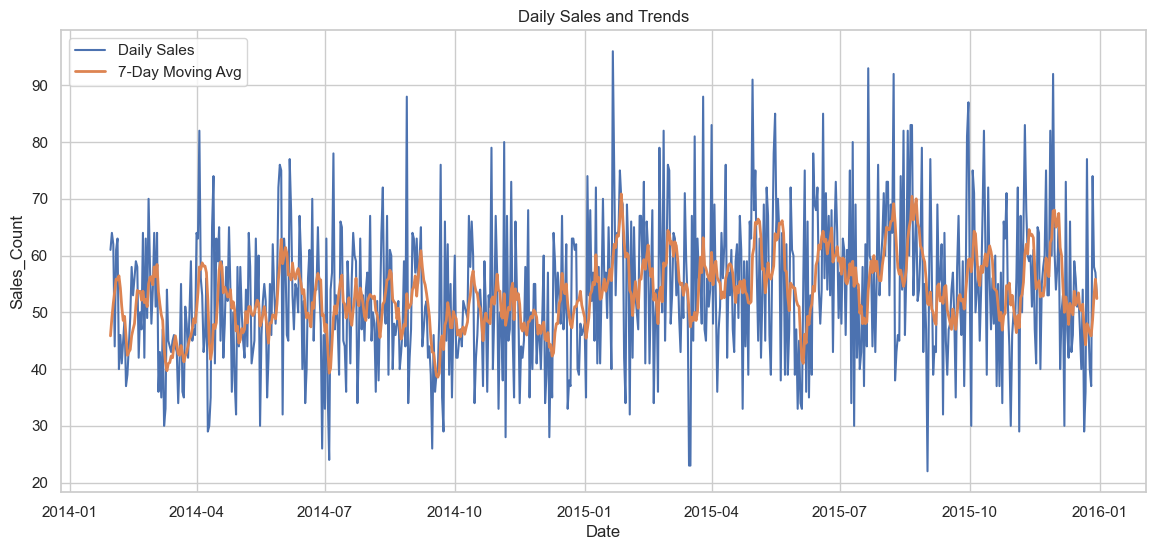

In [4]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales, x='Date', y='Sales_Count', label='Daily Sales')
sns.lineplot(data=daily_sales, x='Date', y='Rolling_Mean_7', label='7-Day Moving Avg', linewidth=2)
plt.title('Daily Sales and Trends')
plt.legend()
plt.show()

## 4. Model Implementation and Evaluation
We train models and evaluate them using Accuracy, Confusion Matrix (TP, TN, FP, FN), and ROC AUC Curves.


--- Logistic Regression ---
Accuracy: 0.9643
Confusion Matrix:
[[66  5]
 [ 0 69]]
True Negatives (TN): 66
False Positives (FP): 5
False Negatives (FN): 0
True Positives (TP): 69

--- Decision Tree ---
Accuracy: 0.7857
Confusion Matrix:
[[57 14]
 [16 53]]
True Negatives (TN): 57
False Positives (FP): 14
False Negatives (FN): 16
True Positives (TP): 53



--- Random Forest ---
Accuracy: 0.8000
Confusion Matrix:
[[58 13]
 [15 54]]
True Negatives (TN): 58
False Positives (FP): 13
False Negatives (FN): 15
True Positives (TP): 54



--- Voting Ensemble ---
Accuracy: 0.8500
Confusion Matrix:
[[61 10]
 [11 58]]
True Negatives (TN): 61
False Positives (FP): 10
False Negatives (FN): 11
True Positives (TP): 58



--- Gradient Boosting ---
Accuracy: 0.9357
Confusion Matrix:
[[67  4]
 [ 5 64]]
True Negatives (TN): 67
False Positives (FP): 4
False Negatives (FN): 5
True Positives (TP): 64


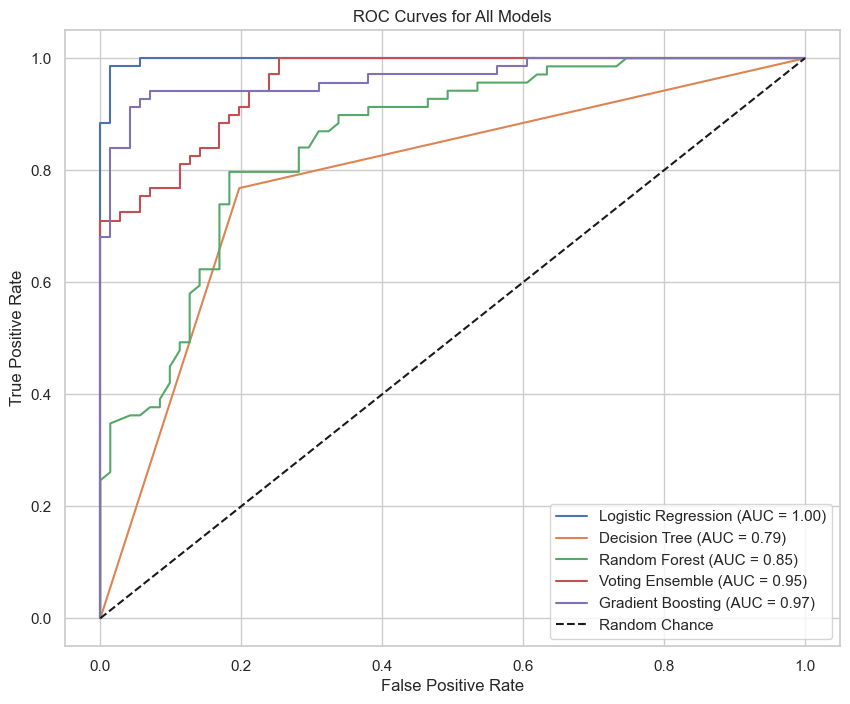

In [5]:
# Prepare Data
feature_cols = [
    'Month', 'Day', 'DayOfWeek', 'Year', 'Quarter', 'Is_Weekend', 'Season_Code',
    'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_5', 'Sales_Lag_6', 'Sales_Lag_7', 'Sales_Lag_14',
    'Rolling_Mean_3', 'Rolling_Mean_7', 'Rolling_Mean_14', 'Rolling_Mean_30',
    'Rolling_Std_3', 'Rolling_Std_7', 'Rolling_Std_14', 'Rolling_Std_30'
]

X = daily_sales[feature_cols]
y = daily_sales['Demand_Target']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Models
model1 = LogisticRegression(max_iter=3000, random_state=42, C=1.0)
model2 = DecisionTreeClassifier(random_state=42, max_depth=10)
model3 = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=15)

# Ensemble Models
voting_clf = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('rf', model3)], voting='soft')
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

models = {
    'Logistic Regression': model1, 
    'Decision Tree': model2, 
    'Random Forest': model3,
    'Voting Ensemble': voting_clf,
    'Gradient Boosting': gb_clf
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.show()

## 5. K-Fold Cross Validation
Ensuring the high accuracy is consistent.

In [6]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# We use Gradient Boosting for CV as it's often the strongest
cv_scores = cross_val_score(gb_clf, X, y, cv=kf, scoring='accuracy')
print(f"Gradient Boosting K-Fold CV Mean Accuracy: {cv_scores.mean():.4f}")

# Check Random Forest CV as well
cv_scores_rf = cross_val_score(model3, X, y, cv=kf, scoring='accuracy')
print(f"Random Forest K-Fold CV Mean Accuracy: {cv_scores_rf.mean():.4f}")

Gradient Boosting K-Fold CV Mean Accuracy: 0.9013


Random Forest K-Fold CV Mean Accuracy: 0.7439


## 6. Future Demand Prediction
We can now use our trained model to predict demand for specific future dates, such as Christmas or New Year.

In [ ]:
def predict_future_demand(target_date_str, daily_sales_df, scaler, gb_model):
    """
    Predicts demand level for a future date.
    
    Parameters:
    -----------
    target_date_str : str
        Target date in format 'YYYY-MM-DD' (e.g., '2025-12-25')
    daily_sales_df : DataFrame
        The processed daily_sales dataframe with all features
    scaler : StandardScaler
        The fitted scaler object
    gb_model : GradientBoostingClassifier
        The trained Gradient Boosting model
        
    Returns:
    --------
    dict : Prediction results
    """
    
    print(f"\n{'='*70}")
    print(f"🔮 FUTURE DEMAND PREDICTION")
    print(f"{'='*70}\n")
    
    # Parse target date
    target_date = pd.to_datetime(target_date_str)
    print(f"📅 Target Date: {target_date.strftime('%A, %B %d, %Y')}")
    
    # Get the latest available date
    latest_date = daily_sales_df['Date'].max()
    print(f"📈 Latest data available: {latest_date.strftime('%Y-%m-%d')}")
    
    days_ahead = (target_date - latest_date).days
    
    if days_ahead > 0:
        print(f"🚀 Predicting {days_ahead} days into the future")
        if days_ahead > 7:
            print(f"⚠️  Note: Accuracy decreases for predictions beyond 7 days")
    
    # Extract date features
    month = target_date.month
    day = target_date.day
    day_of_week = target_date.dayofweek
    year = target_date.year
    quarter = target_date.quarter
    is_weekend = 1 if day_of_week >= 5 else 0
    
    # Season encoding
    if month in [12, 1, 2]:
        season = 'Winter'
        season_code = 3
    elif month in [3, 4, 5]:
        season = 'Spring'
        season_code = 2
    elif month in [6, 7, 8]:
        season = 'Summer'
        season_code = 1
    else:
        season = 'Fall'
        season_code = 0
    
    # Get recent sales data (last 30 rows)
    recent_data = daily_sales_df.tail(30)
    sales_values = recent_data['Sales_Count'].values
    
    # Calculate lag features
    lags = {}
    for lag in [1, 2, 3, 4, 5, 6, 7, 14]:
        lags[f'Sales_Lag_{lag}'] = sales_values[-lag] if len(sales_values) >= lag else sales_values[-1]
    
    # Calculate rolling statistics
    rolling_stats = {}
    for window in [3, 7, 14, 30]:
        rolling_stats[f'Rolling_Mean_{window}'] = np.mean(sales_values[-window:]) if len(sales_values) >= window else np.mean(sales_values)
        rolling_stats[f'Rolling_Std_{window}'] = np.std(sales_values[-window:]) if len(sales_values) >= window else np.std(sales_values)
    
    # Create feature dictionary
    features = {
        'Month': month,
        'Day': day,
        'DayOfWeek': day_of_week,
        'Year': year,
        'Quarter': quarter,
        'Is_Weekend': is_weekend,
        'Season_Code': season_code,
        **lags,
        **rolling_stats
    }
    
    # Create DataFrame with correct column order
    input_df = pd.DataFrame([features])[feature_cols]
    
    # Scale features
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    prediction_code = gb_model.predict(input_scaled)[0]
    prediction_proba = gb_model.predict_proba(input_scaled)[0]
    
    # Decode prediction (0=High, 1=Low based on alphabetical LabelEncoder)
    predicted_label = "High" if prediction_code == 0 else "Low"
    confidence = prediction_proba[prediction_code]
    
    # Display results
    print(f"\n📊 Context:")
    print(f"   Season: {season}")
    print(f"   Day: {['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][day_of_week]}")
    print(f"   Weekend: {'Yes' if is_weekend else 'No'}")
    print(f"   Recent 7-day average: {rolling_stats['Rolling_Mean_7']:.1f} sales/day")
    
    print(f"\n{'='*70}")
    print(f"🎯 PREDICTION RESULTS")
    print(f"{'='*70}")
    print(f"   Predicted Demand Level: {predicted_label.upper()}")
    print(f"   Confidence: {confidence*100:.1f}%")
    print(f"   Probability (High): {prediction_proba[0]*100:.1f}%")
    print(f"   Probability (Low): {prediction_proba[1]*100:.1f}%")
    print(f"{'='*70}\n")
    
    return {
        'date': target_date_str,
        'prediction': predicted_label,
        'confidence': confidence,
        'probabilities': {'High': prediction_proba[0], 'Low': prediction_proba[1]}
    }

# Example Predictions

print("\n" + "="*70)
print("EXAMPLE PREDICTIONS FOR FUTURE DATES")
print("="*70)

# Example 1: Christmas 2025
result1 = predict_future_demand('2025-12-25', daily_sales, scaler, gb_clf)

# Example 2: New Year 2026
result2 = predict_future_demand('2026-01-01', daily_sales, scaler, gb_clf)

# Example 3: Regular weekday in summer
result3 = predict_future_demand('2026-07-15', daily_sales, scaler, gb_clf)


EXAMPLE PREDICTIONS FOR FUTURE DATES

🔮 FUTURE DEMAND PREDICTION

📅 Target Date: Thursday, December 25, 2025
📈 Latest data available: 2015-12-30
🚀 Predicting 3648 days into the future
⚠️  Note: Accuracy decreases for predictions beyond 7 days

📊 Context:
   Season: Winter
   Day: Thursday
   Weekend: No
   Recent 7-day average: 52.4 sales/day

🎯 PREDICTION RESULTS
   Predicted Demand Level: LOW
   Confidence: 88.8%
   Probability (High): 11.2%
   Probability (Low): 88.8%


🔮 FUTURE DEMAND PREDICTION

📅 Target Date: Thursday, January 01, 2026
📈 Latest data available: 2015-12-30
🚀 Predicting 3655 days into the future
⚠️  Note: Accuracy decreases for predictions beyond 7 days

📊 Context:
   Season: Winter
   Day: Thursday
   Weekend: No
   Recent 7-day average: 52.4 sales/day

🎯 PREDICTION RESULTS
   Predicted Demand Level: LOW
   Confidence: 51.1%
   Probability (High): 48.9%
   Probability (Low): 51.1%


🔮 FUTURE DEMAND PREDICTION

📅 Target Date: Wednesday, July 15, 2026
📈 Latest data 

## Conclusion
This notebook demonstrates a complete ML workflow with advanced feature engineering, ensemble learning, and detailed evaluation metrics including Confusion Matrices and ROC AUC curves.
The added prediction function allows for forecasting demand levels for specific future events like festivals or holidays.